In [1]:
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))

sys.path.append(parent_dir)

In [2]:
import torch
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch.nn.utils import rnn as rnn_utils
from generators.data_generation import generate_sequences
from model_managers.DeepLearningManager import DeepLearningManager
torch.cuda.empty_cache()

In [3]:
import matplotlib.pyplot as plt

def plot_sequence(points, direction):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(3, 2))
    
    # Plot the sequence of points
    point_array = np.array(points)
    ax.plot(point_array[:, 0], point_array[:, 1], marker='o', linestyle='-')
    
    # Plot direction arrow
    if direction == 1:  # Clockwise
        start_point = point_array[0]
        end_point = point_array[-1]
        dx = end_point[0] - start_point[0]
        dy = end_point[1] - start_point[1]
        ax.arrow(start_point[0], start_point[1], dx, dy, head_width=0.1, head_length=0.1, fc='k', ec='k')
    elif direction == 0:  # Counterclockwise
        start_point = point_array[-1]
        end_point = point_array[0]
        dx = end_point[0] - start_point[0]
        dy = end_point[1] - start_point[1]
        ax.arrow(start_point[0], start_point[1], dx, dy, head_width=0.1, head_length=0.1, fc='k', ec='k')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Sequence of Points with Direction')
    
    # Show plot
    plt.grid()
    plt.show()


In [4]:
points, directions = generate_sequences(n=128, seed=13)

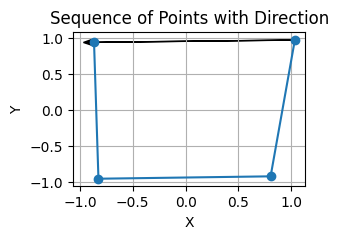

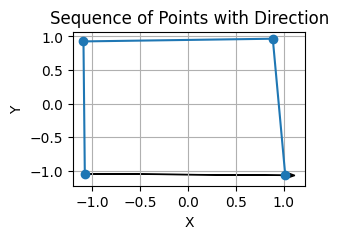

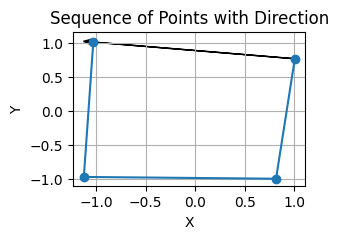

In [5]:

for i in range(3):
    plot_sequence(points[i], directions[i])

# Build a Recurrent Neural Network

In [6]:
n_features = 2
n_hidden_dim = 2

torch.manual_seed(101)
rnn_cell = nn.RNNCell(input_size=n_features, hidden_size=n_hidden_dim)
rnn_state = rnn_cell.state_dict()
rnn_state

OrderedDict([('weight_ih',
              tensor([[-0.4270, -0.0703],
                      [-0.5786,  0.5476]])),
             ('weight_hh',
              tensor([[-0.2978, -0.6808],
                      [ 0.5792, -0.2255]])),
             ('bias_ih', tensor([-0.0977,  0.3286])),
             ('bias_hh', tensor([-0.0317, -0.6058]))])

##### To understand the RNN architecture, we utilize states generated by nn.RNNCell. This allows us to build the architecture from scratch, beginning with linear layers.

In [7]:
# Define the linear layers and get the generated parameters from the RNNCell
linear_input = nn.Linear(n_features, n_hidden_dim)
linear_hidden = nn.Linear(n_hidden_dim, n_hidden_dim)

with torch.no_grad():
    linear_input.weight = nn.Parameter(rnn_state['weight_ih'])
    linear_input.bias = nn.Parameter(rnn_state['bias_ih'])
    linear_hidden.weight = nn.Parameter(rnn_state['weight_hh'])
    linear_hidden.bias = nn.Parameter(rnn_state['bias_hh'])

In [8]:
# Initial hidden state set to 0 with dims 1 x 2
initial_hidden = torch.zeros(1, n_hidden_dim)
initial_hidden

tensor([[0., 0.]])

In [9]:
# We can now generate the first hidden state, this is a simple linear transformation without any activ func
th = linear_hidden(initial_hidden)
th

tensor([[-0.0317, -0.6058]], grad_fn=<AddmmBackward0>)

In [10]:
# Now take the first sequence with 4 points, 2 x 4
X = torch.as_tensor(points[0]).float()
X, X.shape

(tensor([[ 1.0349,  0.9661],
         [ 0.8055, -0.9169],
         [-0.8251, -0.9499],
         [-0.8670,  0.9342]]),
 torch.Size([4, 2]))

In [11]:
tx = linear_input(X[0:1])
tx

tensor([[-0.6076,  0.2589]], grad_fn=<AddmmBackward0>)

In [12]:
# Add the linear transformations to replicate the RNN
adds = th + tx
# Then use the tanh activation function
torch.tanh(adds)

# What we get is the updated hidden state

tensor([[-0.5644, -0.3336]], grad_fn=<TanhBackward0>)

In [13]:
rnn_cell(X[0:1])

tensor([[-0.5644, -0.3336]], grad_fn=<TanhBackward0>)

In [14]:
X[0:1]

tensor([[1.0349, 0.9661]])

## RNN Layer

In [15]:
# Single layer RNN
n_features = 2
n_hidden_dim = 2

torch.manual_seed(101)
rnn_cell = nn.RNN(input_size=n_features, hidden_size=n_hidden_dim)
rnn_state = rnn_cell.state_dict()

# As you can see we have l0 added to the weights and biases that indicates the layer 0
rnn_state

OrderedDict([('weight_ih_l0',
              tensor([[-0.4270, -0.0703],
                      [-0.5786,  0.5476]])),
             ('weight_hh_l0',
              tensor([[-0.2978, -0.6808],
                      [ 0.5792, -0.2255]])),
             ('bias_ih_l0', tensor([-0.0977,  0.3286])),
             ('bias_hh_l0', tensor([-0.0317, -0.6058]))])

### RNN Input Dimension
In PyTorch, if you set the batch_first argument to True when using the nn.RNN class, it adjusts the expected input tensor layout to have the batch dimension first. Therefore, if batch_first is set to True, the input tensor should have dimensions (batch_size, sequence_length, input_size). This is useful for compatibility with certain data formats or personal preference in organizing data.

However, by default, PyTorch's nn.RNN class assumes the sequence dimension comes first. So, if batch_first is not specified or set to False, the input tensor should have dimensions (sequence_length, batch_size, input_size).

In [16]:
batch = torch.as_tensor(points[:3]).float()
batch.shape

/tmp/ipykernel_5905/3502642561.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  batch = torch.as_tensor(points[:3]).float()


torch.Size([3, 4, 2])

In [17]:
# Convert from B S F -> S B F
permuted_batch = batch.permute(1,0,2)

# RNN friendly dimensions: Sequence - batch - Features
permuted_batch.shape

torch.Size([4, 3, 2])

In [18]:
# Batch second
torch.manual_seed(101)
rnn = nn.RNN(input_size=n_features, hidden_size=n_hidden_dim)
out, final_hidden = rnn(permuted_batch)
out.shape, final_hidden.shape

(torch.Size([4, 3, 2]), torch.Size([1, 3, 2]))

In [19]:
# Or use batch_first argument
torch.manual_seed(101)
rnn = nn.RNN(input_size=n_features, batch_first=True ,hidden_size=n_hidden_dim)
out, final_hidden = rnn(batch)
out.shape, final_hidden.shape

(torch.Size([3, 4, 2]), torch.Size([1, 3, 2]))

#### Remember that Datasets and Dataloaders have batch_number as first dimension!

In [20]:
# RNN Layers stacked
torch.manual_seed(101)
rnn_stacked = nn.RNN(input_size=2, hidden_size=2, batch_first=True, num_layers=2)
rnn_stacked_state = rnn_stacked.state_dict()
rnn_stacked_state

OrderedDict([('weight_ih_l0',
              tensor([[-0.4270, -0.0703],
                      [-0.5786,  0.5476]])),
             ('weight_hh_l0',
              tensor([[-0.2978, -0.6808],
                      [ 0.5792, -0.2255]])),
             ('bias_ih_l0', tensor([-0.0977,  0.3286])),
             ('bias_hh_l0', tensor([-0.0317, -0.6058])),
             ('weight_ih_l1',
              tensor([[ 0.1179,  0.3565],
                      [ 0.3747, -0.5031]])),
             ('weight_hh_l1',
              tensor([[ 0.3044, -0.1481],
                      [ 0.1759, -0.1862]])),
             ('bias_ih_l1', tensor([ 0.5406, -0.1774])),
             ('bias_hh_l1', tensor([-0.5009, -0.1880]))])

In [21]:
# RNN Bidirectional
torch.manual_seed(101)
rnn_bidirect = nn.RNN(input_size=2, hidden_size=2, batch_first=True, bidirectional=True)
state = rnn_bidirect.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[-0.4270, -0.0703],
                      [-0.5786,  0.5476]])),
             ('weight_hh_l0',
              tensor([[-0.2978, -0.6808],
                      [ 0.5792, -0.2255]])),
             ('bias_ih_l0', tensor([-0.0977,  0.3286])),
             ('bias_hh_l0', tensor([-0.0317, -0.6058])),
             ('weight_ih_l0_reverse',
              tensor([[ 0.1179,  0.3565],
                      [ 0.3747, -0.5031]])),
             ('weight_hh_l0_reverse',
              tensor([[ 0.3044, -0.1481],
                      [ 0.1759, -0.1862]])),
             ('bias_ih_l0_reverse', tensor([ 0.5406, -0.1774])),
             ('bias_hh_l0_reverse', tensor([-0.5009, -0.1880]))])

In [22]:
# Create forward RNN and backward RNN and pass the parameters to the models
torch.manual_seed(19)
forward_rnn = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
backward_rnn = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
state

OrderedDict([('weight_ih_l0',
              tensor([[-0.4270, -0.0703],
                      [-0.5786,  0.5476]])),
             ('weight_hh_l0',
              tensor([[-0.2978, -0.6808],
                      [ 0.5792, -0.2255]])),
             ('bias_ih_l0', tensor([-0.0977,  0.3286])),
             ('bias_hh_l0', tensor([-0.0317, -0.6058])),
             ('weight_ih_l0_reverse',
              tensor([[ 0.1179,  0.3565],
                      [ 0.3747, -0.5031]])),
             ('weight_hh_l0_reverse',
              tensor([[ 0.3044, -0.1481],
                      [ 0.1759, -0.1862]])),
             ('bias_ih_l0_reverse', tensor([ 0.5406, -0.1774])),
             ('bias_hh_l0_reverse', tensor([-0.5009, -0.1880]))])

In [23]:
[(k[:-8], v) for k, v in list(state.items())[4:]]

[('weight_ih_l0',
  tensor([[ 0.1179,  0.3565],
          [ 0.3747, -0.5031]])),
 ('weight_hh_l0',
  tensor([[ 0.3044, -0.1481],
          [ 0.1759, -0.1862]])),
 ('bias_ih_l0', tensor([ 0.5406, -0.1774])),
 ('bias_hh_l0', tensor([-0.5009, -0.1880]))]

In [24]:
forward_rnn.load_state_dict(dict(list(state.items())[:4]))
backward_rnn.load_state_dict(dict([(k[:-8], v) for k, v in list(state.items())[4:]]))

<All keys matched successfully>

In [25]:
# Convert the state dictionary into a list of key-value pairs and start from the fifth element
state_items = list(state.items())[4:]

# Initialize an empty dictionary to store the modified key-value pairs
modified_state_dict = {}

# Iterate over the key-value pairs obtained from the state dictionary
for key, value in state_items:
    # Modify the key to remove the '_reverse' suffix, assuming it's present
    modified_key = key[:-8]  # Remove the last 8 characters from the key
    # Add the modified key-value pair to the modified state dictionary
    modified_state_dict[modified_key] = value

# Convert the list of modified key-value pairs back into a dictionary
modified_state_dict = dict(modified_state_dict)

# Load the modified state dictionary into the backward RNN model
backward_rnn.load_state_dict(modified_state_dict)


<All keys matched successfully>

In [26]:
X = X.reshape(1,4,2)

In [27]:
# Reverse the sequence input to the backward_rnn
x_rev = torch.flip(X, dims=[1])
x_rev, X

(tensor([[[-0.8670,  0.9342],
          [-0.8251, -0.9499],
          [ 0.8055, -0.9169],
          [ 1.0349,  0.9661]]]),
 tensor([[[ 1.0349,  0.9661],
          [ 0.8055, -0.9169],
          [-0.8251, -0.9499],
          [-0.8670,  0.9342]]]))

In [28]:
out, h = forward_rnn(X)
out, h

(tensor([[[-0.5644, -0.3336],
          [-0.0137, -0.9046],
          [ 0.7210, -0.1233],
          [ 0.0443,  0.8279]]], grad_fn=<TransposeBackward1>),
 tensor([[[0.0443, 0.8279]]], grad_fn=<StackBackward0>))

In [29]:
out_rev, h_rev = backward_rnn(x_rev)
out_rev, h_rev

(tensor([[[ 0.2641, -0.8211],
          [-0.1919,  0.0027],
          [-0.2460,  0.3482],
          [ 0.3624, -0.5167]]], grad_fn=<TransposeBackward1>),
 tensor([[[ 0.3624, -0.5167]]], grad_fn=<StackBackward0>))

In [30]:
torch.cat([out, out_rev], dim=2), torch.cat([h, h_rev])

(tensor([[[-0.5644, -0.3336,  0.2641, -0.8211],
          [-0.0137, -0.9046, -0.1919,  0.0027],
          [ 0.7210, -0.1233, -0.2460,  0.3482],
          [ 0.0443,  0.8279,  0.3624, -0.5167]]], grad_fn=<CatBackward0>),
 tensor([[[ 0.0443,  0.8279]],
 
         [[ 0.3624, -0.5167]]], grad_fn=<CatBackward0>))

In [31]:
rnn_bidirect(X)

(tensor([[[-0.5644, -0.3336,  0.3624, -0.5167],
          [-0.0137, -0.9046, -0.2460,  0.3482],
          [ 0.7210, -0.1233, -0.1919,  0.0027],
          [ 0.0443,  0.8279,  0.2641, -0.8211]]], grad_fn=<TransposeBackward1>),
 tensor([[[ 0.0443,  0.8279]],
 
         [[ 0.3624, -0.5167]]], grad_fn=<StackBackward0>))

# Sequence Training

In [32]:
test_points, test_directions = generate_sequences(seed=101)

In [33]:
# Prepare data
train_data = TensorDataset(torch.as_tensor(points).float(),
                           torch.as_tensor(directions).view(-1,1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(),
                           torch.as_tensor(test_directions).view(-1,1).float())

In [34]:
# Build Dataloaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [35]:
train_loader.dataset[0]

(tensor([[ 1.0349,  0.9661],
         [ 0.8055, -0.9169],
         [-0.8251, -0.9499],
         [-0.8670,  0.9342]]),
 tensor([1.]))

In [36]:
from models.SimpleRNN import SquareModel, SquareModelGRU

In [37]:
model = SquareModel(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [38]:
model_manager = DeepLearningManager(model, loss, optimizer)

In [39]:
# model_manager.set_data_loaders(train_loader=train_loader, val_loader=test_loader)
# model_manager.train(n_epochs=1000)

In [40]:
# fig = model_manager.plot_losses()

In [41]:
# model_manager.loader_apply(test_loader, model_manager.correct)

## GRU Journey

### Why GRU?
GRU, short for Gated Recurrent Unit, addresses a fundamental challenge encountered in simple RNNs: their inability to effectively manage the flow of information from previous hidden states and current inputs. In traditional RNNs, this lack of control often leads to difficulties in retaining relevant information over long sequences, hindering performance in tasks such as sequence prediction and language modeling.

GRU tackles this issue by introducing "gates" into the network architecture. These gates, governed by sigmoid functions, enable precise control over the flow of information within the hidden state computation process. Specifically, GRUs employ two key gates: the update gate and the reset gate.

The update gate regulates the extent to which information from previous time steps should be retained or updated in the current hidden state.
The reset gate determines the degree to which past information should be forgotten or reset, allowing the model to adapt dynamically to changing input patterns.

By incorporating these gating mechanisms, GRU architectures empower neural networks to selectively process and retain relevant information, thereby mitigating the vanishing gradient problem and enhancing the model's ability to capture long-range dependencies in sequential data.

In [42]:
gru_cell = nn.GRUCell(input_size=2, hidden_size=2)
gru_state = gru_cell.state_dict()

The weights and biases represent the 2 gates and the candidate hidden state parameters. The state_dict() method show us the parameters concatenated

In [43]:
# Let's get each parameter
wx, bx = gru_state['weight_ih'], gru_state['bias_ih']
wh, bh = gru_state['weight_hh'], gru_state['bias_hh']
wxr, wxz, wxn = wx.split(2, dim=0)
whr, whz, whn = wh.split(2, dim=0)
bxr, bxz, bxn = bx.split(2, dim=0)
bhr, bhz, bhn = bh.split(2, dim=0)

print("Weight matrices for input-to-hidden connections:")
print("wxr:", wxr)
print("wxz:", wxz)
print("wxn:", wxn)

print("\nWeight matrices for hidden-to-hidden connections:")
print("whr:", whr)
print("whz:", whz)
print("whn:", whn)

print("\nBiases for input-to-hidden connections:")
print("bxr:", bxr)
print("bxz:", bxz)
print("bxn:", bxn)

print("\nBiases for hidden-to-hidden connections:")
print("bhr:", bhr)
print("bhz:", bhz)
print("bhn:", bhn)

Weight matrices for input-to-hidden connections:
wxr: tensor([[ 0.5877, -0.0433],
        [ 0.0206, -0.4003]])
wxz: tensor([[-0.4281, -0.7020],
        [-0.0854,  0.2217]])
wxn: tensor([[-0.4710, -0.0008],
        [ 0.2958,  0.1482]])

Weight matrices for hidden-to-hidden connections:
whr: tensor([[-0.0257,  0.3278],
        [-0.5355, -0.6506]])
whz: tensor([[-0.4902, -0.1010],
        [-0.0822,  0.1418]])
whn: tensor([[-0.0953,  0.1208],
        [ 0.5886,  0.1468]])

Biases for input-to-hidden connections:
bxr: tensor([ 0.1506, -0.2051])
bxz: tensor([-0.3627,  0.3954])
bxn: tensor([0.3411, 0.2989])

Biases for hidden-to-hidden connections:
bhr: tensor([ 0.1785, -0.4399])
bhz: tensor([-0.1145,  0.3320])
bhn: tensor([ 0.3553, -0.3495])


## LSTM - Long Short-Term Memory

The primary distinction between a simple RNN and a GRU cell lies in the presence of an additional state in the LSTM called the cell state. This cell state is crucial in retaining sequential information over extended distances.

In a simple RNN, the network's hidden state is responsible for capturing and propagating information across time steps. However, as sequences grow longer, simple RNNs struggle to maintain relevant information over distant past states due to issues like vanishing gradients.

LSTMs address this limitation by introducing a separate cell state alongside the hidden state. This cell state serves as a conveyor belt for preserving crucial information across multiple time steps. By selectively updating, forgetting, and outputting information through specialized gating mechanisms, LSTMs can effectively capture and retain long-term dependencies in sequential data.

In summary, while both GRUs and LSTMs utilize gating mechanisms to regulate information flow, LSTMs further augment their capacity for modeling long-range dependencies by incorporating an additional cell state, enabling them to excel in tasks that require retaining context over extended sequences. 

In [44]:
lstm_cell = nn.LSTMCell(input_size=2, hidden_size=2)
lstm_state = lstm_cell.state_dict()

In [45]:
# Splitting parameters
wx, bx = lstm_state['weight_ih'], lstm_state['bias_ih']
wh, bh = lstm_state['weight_hh'], lstm_state['bias_hh']

wxi, wxf, wxg, wxo = wx.chunk(4, dim=0)
whi, whf, whg, who = wh.chunk(4, dim=0)
bxi, bxf, bxg, bxo = bx.chunk(4, dim=0)
bhi, bhf, bhg, bho = bh.chunk(4, dim=0)

print("Weight matrices for input-to-hidden connections:")
print("wxi:", wxi)
print("wxf:", wxf)
print("wxg:", wxg)
print("wxo:", wxo)

print("\nWeight matrices for hidden-to-hidden connections:")
print("whi:", whi)
print("whf:", whf)
print("whg:", whg)
print("who:", who)

print("\nBiases for input-to-hidden connections:")
print("bxi:", bxi)
print("bxf:", bxf)
print("bxg:", bxg)
print("bxo:", bxo)

print("\nBiases for hidden-to-hidden connections:")
print("bhi:", bhi)
print("bhf:", bhf)
print("bhg:", bhg)
print("bho:", bho)


Weight matrices for input-to-hidden connections:
wxi: tensor([[ 0.1184, -0.2224],
        [-0.3123, -0.6602]])
wxf: tensor([[-0.3144, -0.2732],
        [-0.5080,  0.1320]])
wxg: tensor([[0.6372, 0.2094],
        [0.2745, 0.0594]])
wxo: tensor([[ 0.4577, -0.0599],
        [ 0.0633, -0.6885]])

Weight matrices for hidden-to-hidden connections:
whi: tensor([[ 0.1029, -0.3099],
        [ 0.0064, -0.5060]])
whf: tensor([[ 0.5263, -0.3318],
        [ 0.4588,  0.2414]])
whg: tensor([[ 0.3229,  0.3237],
        [ 0.7012, -0.4063]])
who: tensor([[-0.2527,  0.3716],
        [ 0.2060, -0.0661]])

Biases for input-to-hidden connections:
bxi: tensor([-0.0284,  0.2737])
bxf: tensor([ 0.5646, -0.3816])
bxg: tensor([-0.6840, -0.1667])
bxo: tensor([-0.2956, -0.4210])

Biases for hidden-to-hidden connections:
bhi: tensor([-0.0686,  0.5996])
bhf: tensor([-0.3023, -0.6971])
bhg: tensor([0.1552, 0.6092])
bho: tensor([0.3639, 0.3216])


In [46]:
from models.SimpleRNN import SquareModelLSTM

In [47]:
model = SquareModelLSTM(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [48]:
model_manager = DeepLearningManager(model, loss, optimizer)
model_manager.set_data_loaders(train_loader=train_loader, val_loader=test_loader)
model_manager.train(n_epochs=100)

2024-03-20 18:09:18,567 - INFO - Epoch: 1/100 || Train Loss: 0.7160572186112404 || Val Loss: 0.7317336201667786
2024-03-20 18:09:18,581 - INFO - Epoch: 2/100 || Train Loss: 0.7042992860078812 || Val Loss: 0.7202576920390129
2024-03-20 18:09:18,595 - INFO - Epoch: 3/100 || Train Loss: 0.6983613446354866 || Val Loss: 0.708670012652874
2024-03-20 18:09:18,609 - INFO - Epoch: 4/100 || Train Loss: 0.6918600797653198 || Val Loss: 0.7024287283420563
2024-03-20 18:09:18,626 - INFO - Epoch: 5/100 || Train Loss: 0.6886776238679886 || Val Loss: 0.6965629607439041
2024-03-20 18:09:18,639 - INFO - Epoch: 6/100 || Train Loss: 0.6849356517195702 || Val Loss: 0.6914988458156586
2024-03-20 18:09:18,653 - INFO - Epoch: 7/100 || Train Loss: 0.6804997324943542 || Val Loss: 0.6848348379135132
2024-03-20 18:09:18,668 - INFO - Epoch: 8/100 || Train Loss: 0.6729291900992393 || Val Loss: 0.674687348306179
2024-03-20 18:09:18,681 - INFO - Epoch: 9/100 || Train Loss: 0.6593726277351379 || Val Loss: 0.65934821218

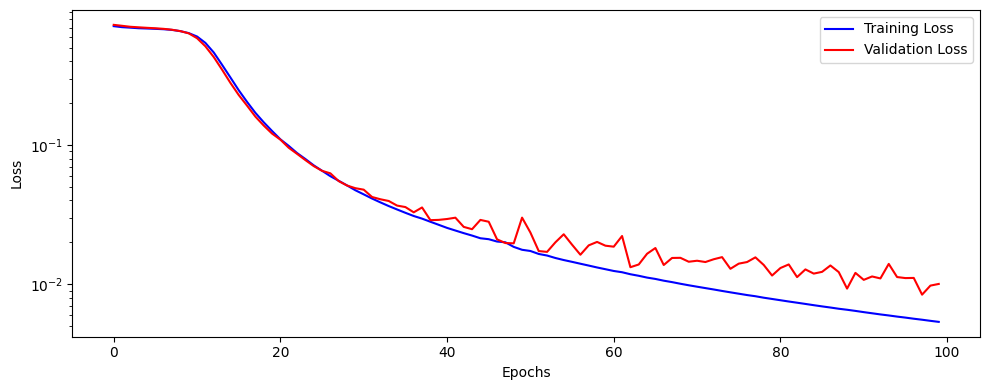

In [49]:
fig = model_manager.plot_losses()

In [50]:
model_manager.loader_apply(test_loader, model_manager.correct)

tensor([[61, 61],
        [67, 67]])

### Sequence Packing

In [51]:
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence, pack_padded_sequence

In [52]:
seq1 = torch.tensor([1, 2, 3, 4])
seq2 = torch.tensor([5, 6])
seq3 = torch.tensor([7, 8, 9])

# Create a list of sequences
sequences = [seq1, seq2, seq3]

In [53]:
packed = pack_sequence(sequences=sequences, enforce_sorted=False)
packed

PackedSequence(data=tensor([1, 7, 5, 2, 8, 6, 3, 9, 4]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

In [54]:
packed.data[[0,3,6,8]]

tensor([1, 2, 3, 4])

At time step 1, the data considered consists of the elements from the original sequences that were active (non-padded) at that time step. The number of active sequences at each time step is indicated by the corresponding value in the batch_sizes tensor.

In the provided batch_sizes tensor [3, 3, 2, 1], each value represents the number of active sequences at the corresponding time step. Therefore, at time step 1, there are 3 active sequences. The data tensor [1, 7, 5, 2, 8, 6, 3, 9, 4] contains the packed data from all sequences, and the batch sizes tensor indicates how many sequences are active at each time step.

So, at time step 1, the data considered would be [1, 7, 5], representing the first elements of the three original sequences in the batch. These values are from the packed data tensor and correspond to the first time step of the sequences before they were padded and packed.

## Train a different lenght sequences

In [55]:
from data_preparation.sequences.diff_size_sequences import VariableSizeDataset
from models.SimpleRNN import SquareModelPacked

In [56]:
var_points, var_directions = generate_sequences(variable_len=True)
var_points[:3]

[array([[ 1.12636495,  1.1570899 ],
        [ 0.87384513, -1.00750892],
        [-0.9149893 , -1.09150317],
        [-1.0867348 ,  1.07731667]]),
 array([[ 0.92250954, -0.89887678],
        [ 1.0941646 ,  0.92300589]]),
 array([[ 0.88696821,  1.0925489 ],
        [ 1.12732504, -1.00405901],
        [-0.90894193, -1.16774959],
        [-1.05484703,  0.90204775]])]

In [57]:
train_var_data = VariableSizeDataset(var_points, var_directions)

In [58]:
train_var_loader = DataLoader(
    train_var_data,
    batch_size=16,
    shuffle=True,
    collate_fn=VariableSizeDataset.pack_collate
)

In [59]:
x_batch, y_batch = next(iter(train_var_loader))

In [60]:
model = SquareModelPacked(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

In [61]:
mm = DeepLearningManager(model, loss, optim)
mm.set_data_loaders(train_var_loader)
mm.train(n_epochs=100)

2024-03-20 18:09:20,351 - INFO - Epoch: 1/100 || Train Loss: 0.7151132524013519 || Val Loss: None
2024-03-20 18:09:20,376 - INFO - Epoch: 2/100 || Train Loss: 0.697898805141449 || Val Loss: None
2024-03-20 18:09:20,404 - INFO - Epoch: 3/100 || Train Loss: 0.6848266199231148 || Val Loss: None
2024-03-20 18:09:20,439 - INFO - Epoch: 4/100 || Train Loss: 0.6726634204387665 || Val Loss: None
2024-03-20 18:09:20,465 - INFO - Epoch: 5/100 || Train Loss: 0.6567975133657455 || Val Loss: None
2024-03-20 18:09:20,493 - INFO - Epoch: 6/100 || Train Loss: 0.6391742005944252 || Val Loss: None
2024-03-20 18:09:20,521 - INFO - Epoch: 7/100 || Train Loss: 0.6153978556394577 || Val Loss: None
2024-03-20 18:09:20,554 - INFO - Epoch: 8/100 || Train Loss: 0.5843691900372505 || Val Loss: None
2024-03-20 18:09:20,581 - INFO - Epoch: 9/100 || Train Loss: 0.544407308101654 || Val Loss: None
2024-03-20 18:09:20,607 - INFO - Epoch: 10/100 || Train Loss: 0.5025576055049896 || Val Loss: None
2024-03-20 18:09:20,6

## 1-D Convolution

In [69]:
import numpy as np

arr = np.array([ 5, 10, 4, 3, 5, 4, 11, 4, 0, 4, 2])
size = 5
weight = torch.ones(size)*0.2
out_tensor = F.conv1d(torch.as_tensor(arr).float().view( 1, 1, -1), weight=weight.view( 1, 1, -1))
out_tensor

tensor([[[5.4000, 5.2000, 5.4000, 5.4000, 4.8000, 4.6000, 4.2000]]])

In [72]:
out_tensor[0][0][0] == sum(arr[:size])*0.2

tensor(True)

### Conv 1-D on Multiple Features/Channels
Default shape conv1d N, F=C, L 

N = Number of sequences (batch_size)

F = C = Features or Channels

L = Sequence length

Convolution of a sequence with 2 features and length of 4 and a single filter 2x2.

1x2x4 (sequence) * 1x2x2 (filter) = 1x1x3 output 

In [73]:
conv_seq = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=2, bias=False)
conv_seq.weight, conv_seq.weight.shape

(Parameter containing:
 tensor([[[ 0.4804, -0.4524],
          [-0.1348, -0.1554]]], requires_grad=True),
 torch.Size([1, 2, 2]))

## Dilation

Dilated convolutions in 1D convolutional neural networks (Conv1D) expand the receptive field without increasing the number of parameters. By introducing gaps between elements in the convolutional filter, a dilation rate greater than 1 allows the filter to cover more input units per convolution, capturing wider-range features without additional computational cost. For instance, with a dilation rate of 2, the filter skips every other input element, effectively broadening its perspective on the input sequence while maintaining the same computational footprint. This technique is especially valuable in processing time series or sequential data, where understanding broader context or longer-range dependencies is crucial.
Dilation take the filter and apply it to the sequence and skip based on dilation number. Dilation = 1 means no skip, must be 2 or more.

In [74]:
conv_dilated = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=2, dilation=2, bias=False)
conv_dilated.weight, conv_dilated.weight.shape

(Parameter containing:
 tensor([[[0.0690, 0.1588],
          [0.0546, 0.3521]]], requires_grad=True),
 torch.Size([1, 2, 2]))